In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import seaborn as sns
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from sklearn.metrics import mean_squared_error

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


## The Network

In [2]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(34,2,0,1)

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [5]:
from model_structures import Dense3layer
net = Dense3layer()
net.apply(initialize_weights)
print(net)

Dense3layer(
  (L_in): Linear(in_features=528, out_features=264, bias=True)
  (batchnorm1): BatchNorm1d(264, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out1): Dropout(p=0.4, inplace=False)
  (L_2): Linear(in_features=792, out_features=396, bias=True)
  (batchnorm2): BatchNorm1d(396, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out2): Dropout(p=0.4, inplace=False)
  (L_3): Linear(in_features=1188, out_features=396, bias=True)
  (batchnorm3): BatchNorm1d(396, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out3): Dropout(p=0.4, inplace=False)
  (L_out): Linear(in_features=396, out_features=1, bias=True)
)


In [6]:
peptide_random = np.random.normal(0,1, (10, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))

output = net(peptide_random,HLA_random)
output

tensor([[0.7144],
        [0.6539],
        [0.7520],
        [0.5423],
        [0.6359],
        [0.2617],
        [0.8087],
        [0.2518],
        [0.7190],
        [0.6143]], grad_fn=<SigmoidBackward0>)

## Functions for loading data

In [7]:
def encode_peptide_onehot(aa_seq):
    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F','P', 'S', 'T', 'W', 'Y', 'V', "-"]
    one_hot_matrix = pd.DataFrame(np.identity(len(amino_acids)).astype("float32"))
    one_hot_matrix.index = amino_acids
    encoded_aa_seq = []

    for aa in aa_seq:
        if aa == "X":
            aa = "-"
        try:    
            encoded_aa_seq.append(one_hot_matrix.loc[aa].to_numpy())
        except KeyError:
            print("Encoding error")
            sys.exit(1)
    

    encoded_aa_seq = np.array(encoded_aa_seq)
    # print(encoded_aa_seq.shape)
    return encoded_aa_seq


def load_blossum62_matrix():
    from Bio.Align import substitution_matrices
    blosum62 = substitution_matrices.load("BLOSUM62")
    blossum_aas = list("ARNDCQEGHILKMFPSTWYVBZX*")
    blosum62 = pd.DataFrame(blosum62,columns=blossum_aas,index=blossum_aas)
    return blosum62


def encode_peptide_blossum65(aa_seq,blussom_matrix):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    AAs = blussom_matrix.shape[1]
    for aa in aa_seq:
        if aa == "-":
            encoded_aa_seq.append(np.array([0 for _ in range(AAs)]))
        else:
            try:
                encoded_aa_seq.append(blussom_matrix.loc[aa].to_numpy())
            except KeyError:
                print("Encoding error")
                sys.exit(1)
    

    encoded_aa_seq = np.array(encoded_aa_seq)
    # print(encoded_aa_seq.shape)

    return encoded_aa_seq


def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)


def encode_dataset(df,encoding_matrix,HLA_dict,peptide_len,padding="right"):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        # encoded_peptide = encode_peptide_aaindex(peptide,encoding_matrix,row)
        encoded_peptide = encode_peptide_onehot(peptide)
        # encoded_peptide = encode_peptide_blossum65(peptide,encoding_matrix)
        binding_score = row['binding_score']

        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        # encoded_HLA = encode_peptide_aaindex(HLA,encoding_matrix,row)
        encoded_HLA = encode_peptide_onehot(HLA)
        # encoded_HLA = encode_peptide_blossum65(HLA,encoding_matrix)


        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32').reshape(-1,1)
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32').reshape(-1,1)
    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Functions for plotting model statistics

In [8]:
def plot_epochs(K, lst_train_acc, lst_val_acc): 
    plt.figure()
    for i in range(K):
        epoch = np.arange(len(lst_train_acc[i]))
        plt.plot(epoch, lst_train_acc[i], 'r', epoch, lst_val_acc[i], 'b')
    plt.title("Performance of {} fold CV".format(K))
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')
    plt.show()


def calculate_avg_val_performance(K, N, lst_val_acc, lst_val_lab, lst_val_pred):
    """Calculate the generalization error

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        N (int): Total number of observations in data set
    """
    avg_recall = 0
    avg_accuracy = 0 
    avg_f1 = 0

    res = np.zeros((K,5))
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        n = len(lst_val_lab[i][best_epoch_model])
        accuracy = accuracy_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        recall = recall_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        f1 = f1_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])

        res[i][0] = best_epoch_model
        res[i][1] = n
        res[i][2] = accuracy
        res[i][3] = recall
        res[i][4] = f1

        avg_recall += (n/N) * recall
        avg_accuracy += (n/N) * accuracy
        avg_f1 += (n/N) * f1

    print(f"Best average results - Recall: {avg_recall} accuracy: {avg_accuracy} f1-score: {avg_f1}")
    return res

def plot_roc_curve_best_epoch(valid_losses, predictions, targets):
    best_epoch_model = np.argmin(valid_losses)
    fpr, tpr, threshold = metrics.roc_curve(targets[best_epoch_model],predictions[best_epoch_model])
    roc_auc = metrics.auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_PR_curve_best_epoch(valid_losses, predictions, targets):
    from sklearn import metrics
    best_epoch_model = np.argmin(valid_losses)
    precision, recall, thresholds = metrics.precision_recall_curve(targets[best_epoch_model], predictions[best_epoch_model])
    roc_auc = metrics.auc(recall, precision)
    plt.title('Receiver Operating Characteristic')
    plt.plot(recall, precision, 'b', label = 'AUCpr = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## Functions for training the models

In [9]:
def plot_learning_curve(train_accuracies,val_accuracies):
    epoch = np.arange(len(train_accuracies))
    plt.figure()
    plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')


def validation(model,device,valid_loaders,train_loaders):
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    with torch.no_grad():
        all_train_predictions = []
        all_train_targets = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i].to(device)
            train_HLA = HLA_train_loader[i].to(device)
            train_labels = label_train_loader[i].to(device)
            train_binding_scores = binding_score_train_loader[i].to(device)
            outputs = model(train_peptides,train_HLA)
            all_train_predictions += outputs.cpu().numpy().tolist()
            all_train_targets += train_labels.cpu().numpy().tolist()
        
        all_val_targets = []
        all_val_predictions = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j].to(device)
            val_HLA = HLA_val_loader[j].to(device)
            val_labels = label_val_loader[j].to(device)
            val_binding_scores = binding_score_val_loader[j].to(device)
            outputs = model(val_peptides,val_HLA)
            all_val_predictions += outputs.cpu().numpy().tolist()
            all_val_targets += val_labels.cpu().numpy().tolist()


        validation_loss = mean_squared_error(all_val_targets,all_val_predictions)

    return all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,validation_loss


def train(model, device, epochs, train_loaders, valid_loaders):
    
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    # Early stopping
    the_last_loss = 100
    patience = 5
    trigger_times = 0
    
    all_val_targets_pr_epoch = []
    all_val_predictions_pr_epoch = []

    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        current_loss = 0
        
        for train_batch_index in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[train_batch_index].to(device)
            train_HLA = HLA_train_loader[train_batch_index].to(device)
            train_labels = label_train_loader[train_batch_index].to(device)
            train_binding_scores = binding_score_train_loader[train_batch_index].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(train_peptides,train_HLA)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
        train_losses.append(current_loss/len((peptide_train_loader)))

        all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,validation_loss = validation(model,device,valid_loaders,train_loaders)
        val_losses.append(validation_loss)
        all_val_targets_pr_epoch.append(all_val_targets)
        all_val_predictions_pr_epoch.append(all_val_predictions)

        if epoch % 1 == 0:
            print("Epoch %2i : Train Loss %f , Validation loss %f" % (epoch+1, train_losses[-1], val_losses[-1]))
        

        # Early stopping
        the_current_val_loss = val_losses[-1]
        the_last_val_loss = 0 if len(val_losses) < 2 else val_losses[-2]

        # print('The current valdiation loss:', the_current_loss)
        # print(the_current_val_loss,the_last_val_loss)
        if the_current_val_loss > the_last_val_loss:
            trigger_times += 1
            # print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping at epoch',epoch," with patience",patience)
                return model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch

        else:
            # print('trigger times: 0')
            trigger_times = 0

    return model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)


Device state: cpu


## Encoding entire data set

In [10]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
blosum62 = load_blossum62_matrix()

hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

all_data = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_IFNg_assay_w_parts.csv")
all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)

# Blossum-encoding
# all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,blosum62,hla_dic,peptide_len=10,padding="right")
# AAindex Encoding
all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
# One-hot encoding
# all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,[],hla_dic,peptide_len=10,padding="right")
print("Shape of peptides",all_peptides_encoded.shape)
print("Shape of hla",all_HLA_encoded.shape)
print("Shape of binding_scores",all_binding_scores_encoded.shape)

Shape of peptides (5543, 10, 21)
Shape of hla (5543, 34, 21)
Shape of binding_scores (5543, 1)


## 5-fold cross-validation loop

In [10]:
N = len(all_data)
K = 1
no_epoch = 60

testing = False
part_dict = {0:[0,1], 1:[2,3], 2:[4,5], 3:[6,7], 4:[8,9]}
part_dict_testing = {0:[1,2], 1:[3,4], 2:[5,6], 3:[7,8], 4:[9]}
partitions = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100

lst_train_accuracies = []

lst_val_losses = []
lst_val_predictions = []
lst_val_labels = []


for i in range(K):
    if testing == True:
        ## The partitions to use for training, validation ##
        testing_parts = [0]
        validation_parts = part_dict_testing[i]
        training_parts = [j for j in range(1,10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

        test_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(testing_parts)]
        test_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(testing_parts)]
        test_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(testing_parts)]
        test_label_encoded = all_label_encoded[all_data["parts"].isin(testing_parts)]

        peptide_test = test_peptides_encoded.reshape(-1,1,10,12)
        HLA_test = test_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
        binding_test = test_binding_scores_encoded.reshape(-1)
        label_test = test_label_encoded.reshape(-1)

        peptide_test_loader = list(DataLoader(peptide_test,batch_size=len(peptide_test)))
        HLA_test_loader = list(DataLoader(HLA_test,batch_size=len(peptide_test)))
        label_test_loader = list(DataLoader(label_test,batch_size=len(peptide_test)))
        binding_score_test_loader = list(DataLoader(binding_test,batch_size=len(peptide_test)))

    else:

        ## The partitions to use for training, validation ##
        validation_parts = part_dict[i]
        training_parts = [j for j in range(10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

    train_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(training_parts)]
    train_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(training_parts)]
    train_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(training_parts)]
    train_label_encoded = all_label_encoded[all_data["parts"].isin(training_parts)]

    val_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(validation_parts)]
    val_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(validation_parts)]
    val_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(validation_parts)]
    val_label_encoded = all_label_encoded[all_data["parts"].isin(validation_parts)]


    ## Batches for training the model ##
    peptide_train_loader = list(DataLoader(train_peptides_encoded,batch_size=batch_size))
    HLA_train_loader = list(DataLoader(train_HLA_encoded,batch_size=batch_size))
    binding_score_train_loader = list(DataLoader(train_binding_scores_encoded,batch_size=batch_size))
    label_train_loader = list(DataLoader(train_label_encoded,batch_size=batch_size))

    peptide_val_loader = list(DataLoader(val_peptides_encoded,batch_size=batch_size))
    HLA_val_loader = list(DataLoader(val_HLA_encoded,batch_size=batch_size))
    binding_score_val_loader = list(DataLoader(val_binding_scores_encoded,batch_size=batch_size))
    label_val_loader = list(DataLoader(val_label_encoded,batch_size=batch_size))

    train_loaders = (peptide_train_loader, HLA_train_loader, label_train_loader, binding_score_train_loader)
    val_loaders = (peptide_val_loader, HLA_val_loader, label_val_loader, binding_score_val_loader)

    net = Net()
    net.apply(initialize_weights)

    trained_model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch= train(net,device,no_epoch,train_loaders,val_loaders)

    lst_train_accuracies.append(train_losses)
    lst_val_losses.append(val_losses)
    lst_val_labels.append(all_val_targets_pr_epoch)
    lst_val_predictions.append(all_val_predictions_pr_epoch)
    
    if testing == True:
        test_outputs = trained_model(peptide_test_loader[0],HLA_test_loader[0],binding_score_test_loader[0])
        probability,predicted_labels =  torch.max(test_outputs, 1)
        test_accuracies = accuracy_score(label_test,predicted_labels)


the val and train parts
[0, 1] [2, 3, 4, 5, 6, 7, 8, 9]
Epoch  1 : Train Loss 0.239210 , Validation loss 0.220247
Epoch  2 : Train Loss 0.201979 , Validation loss 0.198194
Epoch  3 : Train Loss 0.191465 , Validation loss 0.192055
Epoch  4 : Train Loss 0.185761 , Validation loss 0.188727
Epoch  5 : Train Loss 0.179411 , Validation loss 0.181994
Epoch  6 : Train Loss 0.172112 , Validation loss 0.180175
Epoch  7 : Train Loss 0.167944 , Validation loss 0.179551
Epoch  8 : Train Loss 0.165944 , Validation loss 0.175866
Epoch  9 : Train Loss 0.161498 , Validation loss 0.182421
Epoch 10 : Train Loss 0.157408 , Validation loss 0.174391
Epoch 11 : Train Loss 0.151962 , Validation loss 0.173956
Epoch 12 : Train Loss 0.150689 , Validation loss 0.174339
Epoch 13 : Train Loss 0.151282 , Validation loss 0.173193
Epoch 14 : Train Loss 0.150245 , Validation loss 0.172813
Epoch 15 : Train Loss 0.142404 , Validation loss 0.172203
Epoch 16 : Train Loss 0.138168 , Validation loss 0.175967
Epoch 17 : Train

## Statistics for network

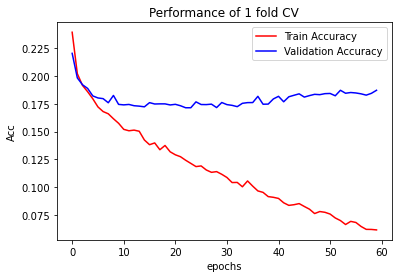

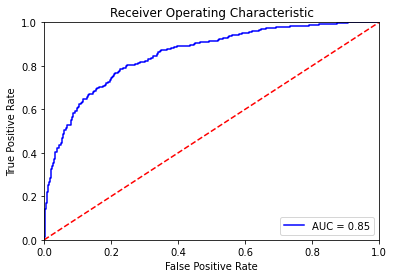

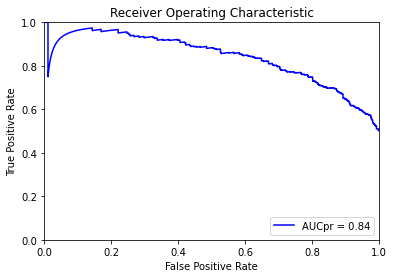

In [11]:
# line plot
plot_epochs(K, lst_train_accuracies, lst_val_losses)
plot_roc_curve_best_epoch(lst_val_losses[0],lst_val_predictions[0],lst_val_labels[0])
plot_PR_curve_best_epoch(lst_val_losses[0],lst_val_predictions[0],lst_val_labels[0])